# Solving the Five-Player Intransitive Dice Problem

## Introduction

For information on this problem, check out my solution for [the four-player intransitive dice problem](https://github.com/NGeorgescu/math_problems/blob/main/intransitive.ipynb).  The five-player problem seeks to extend the solution to a fifth player.

There was an open question in the original post which we will answer here: why are the working numbers of dice only primes that are 7 (mod 8)?

In [1]:
# First let's import
import sympy as sp
import itertools as it
from tabulate import tabulate
from fractions import Fraction
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

first let us consider the list of numbers that are inverse (mod 23) of each other between n=23.  These numbers always come in pairs because `a*b=1 (mod n)` is a symmetric equation about a and b. The only exception are 1 and n-1, which are inverse mods of themselves.  It should not take much convincing that the equation can only be satisfied by b=1 if a=1, and by symmetry one can work out the same for n-1 (think of stepping backwards around a clock face)

In [2]:
n=23
{tuple(sorted((i,pow(i,-1,n)))) for i in range(1,n)}

{(1, 1),
 (2, 12),
 (3, 8),
 (4, 6),
 (5, 14),
 (7, 10),
 (9, 18),
 (11, 21),
 (13, 16),
 (15, 20),
 (17, 19),
 (22, 22)}

Thus we have the constraint that if a is in our array, then the inverse mod should also be in the list such that the first constraint presented in the four-player problem is solved.

In order to help visualize the inverse mod relationship, one can make a network graph about the nodes, with connecting lines between the inverse mods.

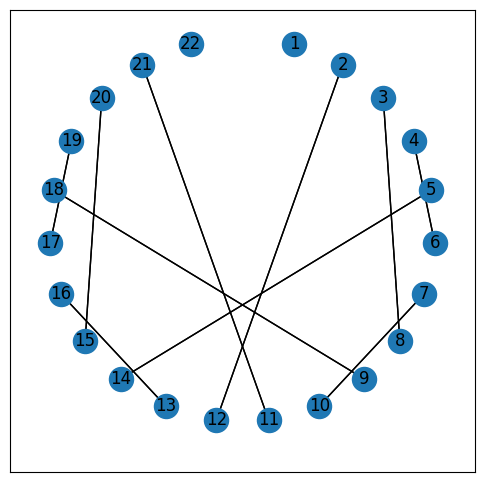

In [3]:
n=23
plt.figure(figsize=(6,6))
plt.axis('equal')
edges = {tuple((i,pow(i,-1,n))) for i in range(2,n-1)}
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
pos = {i: (np.sin(angle), np.cos(angle)) for i, angle in enumerate(angles)}
G = nx.DiGraph() 
G.add_edges_from(edges.union({(1,1),(n-1,n-1)})) 
nx.draw_networkx_edges(G, pos, arrows = False, edgelist=edges)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()


Furthermore, we have the second constraint that if a is in our array, we must omit n-a, since the inclusion of both some value a and n-a would result in the two faces adding to a constant value, and thus cancelling each other out. This exclusion greatly reduces the parameter space by (nearly) a factor of four, since the inclusion of a necessarily includes the inverse mod b, and excludes n-a and n-b, which are inverse mods of each other.  

In [4]:
{tuple(sorted((
    tuple(sorted((i,pow(i,-1,n)))),
     tuple(sorted((n-i,n-pow(i,-1,n))))))) for i in range(1,n)}

{((1, 1), (22, 22)),
 ((2, 12), (11, 21)),
 ((3, 8), (15, 20)),
 ((4, 6), (17, 19)),
 ((5, 14), (9, 18)),
 ((7, 10), (13, 16))}

Now the reason that primes of the form 4k+1 (pythagorean primes) don't work should be immediately apparent: it's impossible to satisfy both of those constraints because we would be left with at least one unpaired pair of values. Thus every pythagorean prime contains an odd number of (and thus at least one value of) a such that `invmod(a,n) = n-a`.  The list is given by:

In [5]:
print([next((j for j in range(2,n-1) if pow(j,-1,n)==n-j))  for n in range(1,1000,4) if sp.isprime(n)])

[2, 5, 4, 12, 6, 9, 23, 11, 27, 34, 22, 10, 33, 15, 37, 44, 28, 80, 19, 81, 14, 107, 89, 64, 16, 82, 60, 53, 138, 25, 114, 148, 136, 42, 104, 115, 63, 20, 143, 29, 179, 67, 109, 48, 208, 235, 52, 118, 86, 24, 77, 125, 35, 194, 154, 149, 106, 58, 26, 135, 96, 353, 87, 39, 62, 317, 215, 318, 295, 246, 333, 207, 151, 387, 324, 196, 97, 442, 252, 161]


which one can find at https://oeis.org/A002314 . Therefore, for all n=4k+1, it is impossible to have an array that is it's own inverse mod that does not contain it's own compliment.

## Okay, `4k+1` does not work, but what about `8k+3`?

**Edit: 2025-04-15** - a much, much simpler explanation than I previously had now follows.

So the reason that `8k+7` is the only one that works is for a the following reason: Consider the application of the "balanced mod" operation, `bmod`, which is defined as the modulo balanced about 0, such that it goes from -(n-1)/2 to (n-1)/2. It can be shown that we really are interested in operations wherein the `bmod(sum(array))%n==0`.

Consider the set of numbers *S = { ±1, ±2, ..., ± (n-1)/2}*.  (We know that if some value of the bmod operation, *s*, is in our set, then *-s* is not, in order to satisfy the condition of the dice).  Therefore it is only satisfiable if there exists a choice of \\(ϵ_k\\) ∈{−1,1} such that the sum of (\\(ϵ_k\\)⋅k for all S)=0. This is only possible when n=7 (mod 8).

For example, for Oskar's original dice, his set is *{1,2,4}* (or equivalently, *{1,2,-3}*)  which works because 1 and 3 are the odd numbers that construct the set and therefore it can equal zero with appropriate signs.  However, a set of 11 dice would not work because there is no way to add or subtract {1,2,3,4,5} and end up with zero.  There are three odd numbers in there and therefore you will always be off by one. 

Therefore *n = 8k+7* is the only dice count that works because *4k+1* will include an element which is it's own negative bmod, which is not allowed, and *8k+3* will not be able to sum to zero to maintain the symmetry of the dice.

# Checking zeros for possible solutions based on the possible switches

If we then view these sums as switch values that we flip, we reduce the search space by `2**(n//2)` which is a massive gain for large n.  


In [6]:
def bmod(i,n): return (i+n//2)%n-n//2 
def inc(s,n): return sum([bmod(i,n) for i in set(s)])
def get_poss_arr_pairs(n): return tuple(sorted(set([tuple(sorted([(i,j),(n-j,n-i)])) for i,j in {tuple(sorted([i,pow(i,-1,n)])) for i in range(1,n)}])))
def poss_switches_s(n): return sorted([[abs(inc(i,n)-inc(j,n)),[i,j][::1 if inc(i,n)<inc(j,n) else -1]] for i,j in get_poss_arr_pairs(n)])
    
def poss_n(maximum=110): return [n for n in sp.primerange(1,maximum) if not (n+1)%8]
def get_all_comb(n): return it.combinations(range(n), get_players(n)-1)
def of_equal_len(arr,n): return len(set(map(len,get_winners(get_dice(arr,n)))))==1
    
def get_players(n): return sum([n>=i for i in [1, 3, 7, 19, 67, 331, 1163]])
def get_dice(arr,n): return tuple(sorted((tuple((n//2+i*j)%n for i in arr) for j in range(n))))
def get_full_dice(arr,n): return tuple(sorted((tuple((n//2+i*j)%n+k*n for k,i in enumerate(arr)) for j in range(n))))
def get_win_bias(d1,d2): return sum(((j<i)-(i<j) for i,j in zip(d1,d2)))
def get_winners(dice): return tuple(tuple(d1[0] for d1 in dice if get_win_bias(d1,d2)>0) for d2 in dice)
def get_coverage_rate(winners,samples): 
    set_winners = list(map(set,winners))
    return sum(any(all(i in w for i in s) for w in set_winners) for s in samples)/len(samples)

We can then solve for each possible switch combination, and check that the resulting vector has full coverage of all possible combinations of opponents' dice.  Note that the calculation for n=103 should take about 4 hours (and n=79 a few minutes) on a moderate spec laptop with no parallelization or use of pypy.  Hence a cached set of values is presented here:

In [7]:
# cached
working_arr = [(1, 2, 4),
(1, 2, 3, 4, 6, 8, 9, 12, 13, 16, 18),
(1, 2, 4, 5, 7, 8, 9, 10, 14, 16, 18, 19, 20, 25, 28),
(1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 16, 17, 18, 21, 24, 25, 27, 28, 32, 34, 36, 37, 42),
(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 16, 18, 19, 20, 24, 25, 27, 29, 30, 32, 36, 37, 38, 40, 43, 45, 48, 49, 50, 54, 57, 58, 60, 64),
(1, 2, 4, 5, 8, 9, 10, 11, 13, 16, 18, 19, 20, 21, 22, 23, 25, 26, 31, 32, 36, 38, 40, 42, 44, 45, 46, 49, 50, 51, 52, 55, 62, 64, 65, 67, 72, 73, 76)]

def solve_working_arr():
    working_arr = []
    for n in poss_n():
        solutions = [tuple(sorted(i)) for i in ({k for j in i for k in j} for i in it.product(*get_poss_arr_pairs(n))) 
                 if 1 in i 
                 and not sum(i)%n and of_equal_len(i,n) 
                 and get_coverage_rate(get_winners(get_dice(i,n)),tuple(get_all_comb(n)))==1.0]
        print(n,solutions)
        working_arr.extend(solutions)
    return working_arr

We can also check the win rate for each n with a working solution:

In [8]:

fracs = [[n, frac,float(frac[0])]
 for arr in working_arr
 for n in [len(arr)*2+1] 
 for dice in [get_full_dice(arr,n)]
 for frac in [list({k for k in [ Fraction(sum(I>J for I in i for J in j),len(i)*len(j)) for i in dice for j in dice if i!=j] if k>.5})]]


print(tabulate(fracs,headers=('n','fraction list','decimal')))


  n  fraction list            decimal
---  ---------------------  ---------
  7  [Fraction(5, 9)]        0.555556
 23  [Fraction(62, 121)]     0.512397
 31  [Fraction(38, 75)]      0.506667
 47  [Fraction(267, 529)]    0.504726
 71  [Fraction(88, 175)]     0.502857
 79  [Fraction(763, 1521)]   0.501644


It makes sense that as n increases, the number of faces increases, and thus the fractional bias decreases.  The denominator can be worked out to be `(4*(n+1)//8-1)**2`, but the numerator seems rather arbitrary.  Plotted here is the bias for the numerator for each n:

In [9]:
def denom(n): return (4*(n+1)//8 -1)**2
print(tabulate([[n,int(f[0]*denom(n)*2-denom(n))] for n,f,_ in fracs],headers=('n','bias')))

  n    bias
---  ------
  7       1
 23       3
 31       3
 47       5
 71       7
 79       5


# The solution to the five-player problem

We can then plug in and see the working set of faces for a set of 71 dice which solve the five-player non-transitive dice problem:

In [10]:
arr = [i for i in working_arr if len(i)==35][-1]
dice = get_full_dice(arr,len(arr)*2+1)
print(tabulate(dice))

--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  107  143  250  286  393  465  501  608  680  717  824  896  932  1039  1112  1148  1220  1292  1399  1471  1544  1580  1687  1759  1796  1868  1976  2012  2119  2192  2229  2336  2408  2481
 1  109  146  254  291  399  473  510  618  692  732  840  914  951  1059  1065  1173  1247  1321  1358  1432  1509  1617  1654  1728  1839  1913  1953  1990  2098  2175  2215  2323  2397  2474
 2  111  149  258  296  405  481  519  628  704  747  785  861  970  1008  1089  1198  1274  1279  1388  1464  1545  1583  1692  1768  1811  1887  1930  2039  2077  2158  2201  2310  2386  2467
 3  113  152  262  301  411  489  528  638  645  762  801  879  989  1028  1113  1152  1230  1308  1418  1425  1510  1620  1659  1737  1783  1861  1978  2017  2127  2141  2258  2297  2375  2460
 4  115  155  266  306  417  4

We can also check for each die (rows, zero indexed), which die it beats:

In [11]:
winners = get_winners(dice)

print(tabulate([[j for j in i if k<j]+[j for j in i if k>j] for k,i in enumerate(map(sorted,winners))]))

--  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --
 1   2   3   4   5   6   8   9  10  12  15  16  18  19  20  24  25  27  29  30  32  36  37  38  40  43  45  48  49  50  54  57  58  60  64
 2   3   4   5   6   7   9  10  11  13  16  17  19  20  21  25  26  28  30  31  33  37  38  39  41  44  46  49  50  51  55  58  59  61  65
 3   4   5   6   7   8  10  11  12  14  17  18  20  21  22  26  27  29  31  32  34  38  39  40  42  45  47  50  51  52  56  59  60  62  66
 4   5   6   7   8   9  11  12  13  15  18  19  21  22  23  27  28  30  32  33  35  39  40  41  43  46  48  51  52  53  57  60  61  63  67
 5   6   7   8   9  10  12  13  14  16  19  20  22  23  24  28  29  31  33  34  36  40  41  42  44  47  49  52  53  54  58  61  62  64  68
 6   7   8   9  10  11  13  14  15  17  20  21  23  24  25  29  30  32  34  35  37  41  42  43  45  48  50  53  54  55  59  62  63  65  69
 7   8   9  10  11  12  14 

We can do a sanity check that this is a circularly symmetric set (that each die beats the same ones in a set)

In [12]:
n=len(winners)
print(list({tuple(sorted([(j-k)%n for j in i])) for k,i in enumerate(winners)}))

[(1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 16, 18, 19, 20, 24, 25, 27, 29, 30, 32, 36, 37, 38, 40, 43, 45, 48, 49, 50, 54, 57, 58, 60, 64)]


And we can plot this as the node of the directed graph for which the die dominates (one die is shown, all others are cyclically symmetric)

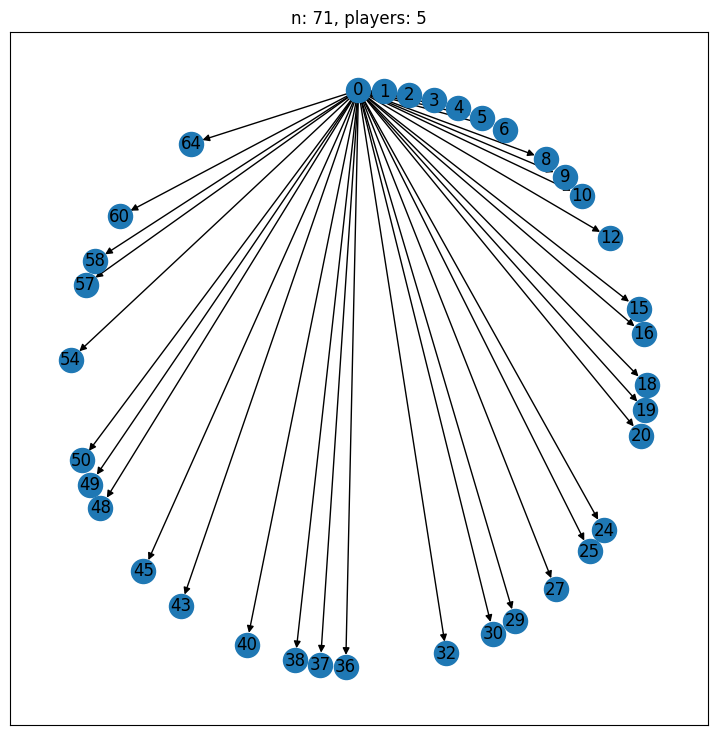

In [13]:
def graph_winners(winners,figsize=(9,9)):
    edges = {(0,i) for i in winners[0]}
    plt.figure(figsize=figsize)
    plt.axis('equal')
    angles = np.linspace(0, 2 * np.pi, len(winners), endpoint=False)
    pos = {i: (np.sin(angle), np.cos(angle)) for i, angle in enumerate(angles)}
    G = nx.DiGraph() 
    G.add_edges_from(edges) 
    nx.draw_networkx_edges(G, pos, edgelist=edges)
    nx.draw_networkx_nodes(G, pos);
    nx.draw_networkx_labels(G, pos)
    plt.title(f'n: {len(winners)}, players: {get_players(len(winners))}')
    plt.show()
    
graph_winners(winners)

Here they are for all n:

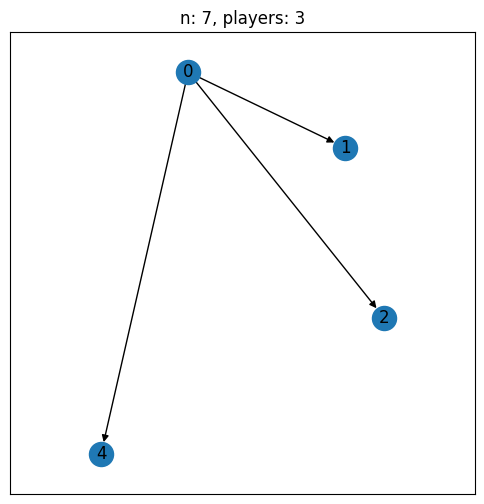

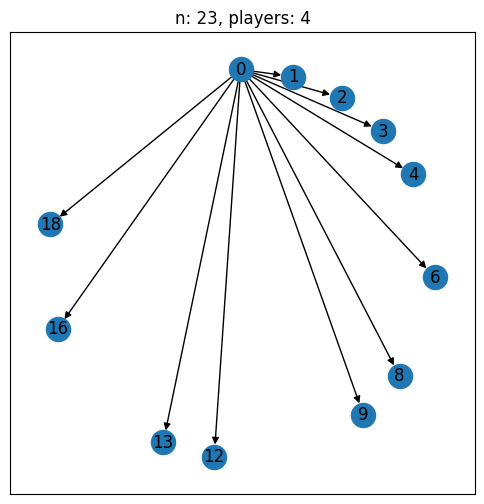

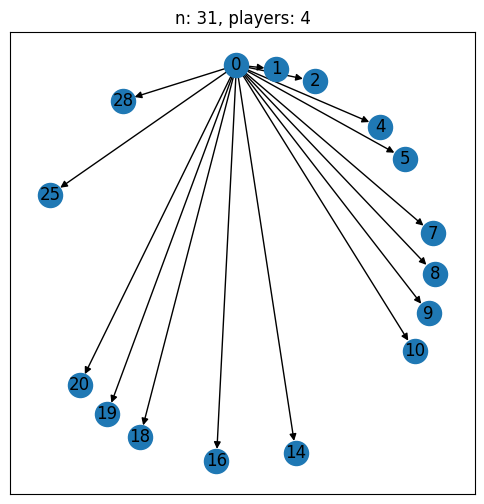

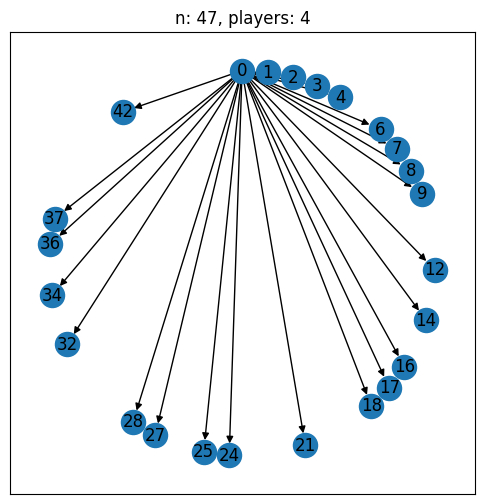

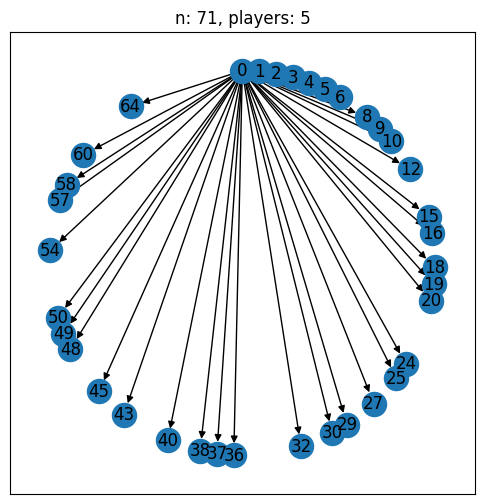

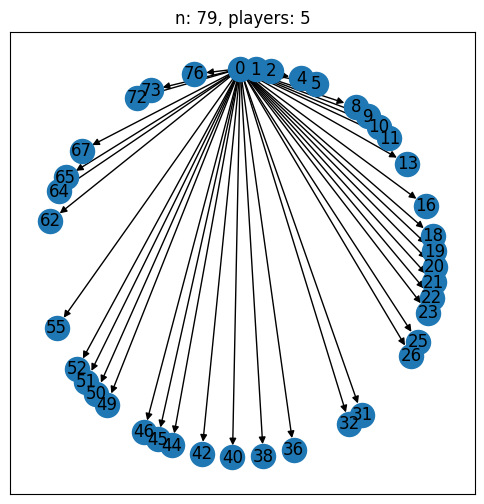

In [14]:
[graph_winners(get_winners(get_full_dice(arr,len(arr)*2+1)),figsize=(6,6)) for arr in working_arr];

# Another solution found by Youhua Li

[Another github user](https://github.com/YouhuaLi/Intransitive_dice) suggested another solution for the four-player problem which uses more faces but only 19 dice (the minimum number given by the acyclic domination graph), given by:

In [15]:
def youhua_li_dice(w):
    n = len(w)*2+1
    return list(zip(*sorted([[(i+j*k)%n+i*n*len(w)+w.index(j)*n for k in range(n)] for i in range(n) for j in w])))

print('dice shown as columns:') 
print(tabulate(list(zip(*youhua_li_dice((1, 4, 5, 6, 7, 9, 11, 16, 17))))))


dice shown as columns:
----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18
  19    23    27    31    35    20    24    28    32    36    21    25    29    33    37    22    26    30    34
  38    43    48    53    39    44    49    54    40    45    50    55    41    46    51    56    42    47    52
  57    63    69    75    62    68    74    61    67    73    60    66    72    59    65    71    58    64    70
  76    83    90    78    85    92    80    87    94    82    89    77    84    91    79    86    93    81    88
  95   104   113   103   112   102   111   101   110   100   109    99   108    98   107    97   106    96   105
 114   125   117   128   120   131   123   115   126   118   129   121   132   124   116   127   119   130   122
 133   149   146   143   140   137   134   150   147   144   141   138   

The number of faces is equal to n*(n-1)/2, which is 171 faces for 19 dice.  Furthermore, it should be noted that this methodology appears to be extensible for any argument to the function that is the cyclic domination set for any directed graph.  Thus a possible solution for the five-player problem is the 2485-faced dice given by applying `youhua_li_dice` function to the `working_arr` for 71 above, or for the 67-player domination graph solution.

# Further challenges

- Can the size of the faces and dice be decreased from either solution found here?
- The calculation for n=359 for my dice seems computationally exorbitant. Is there any trick to reduce the computational complexity?